In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from transformers import AutoTokenizer, AutoModelForCausalLM
from PIL import Image

In [22]:
class Processor:
    def __init__(self, tokenizer_path, num_image_tokens=256):
        self.tokenizer_path = tokenizer_path
        self.image_size = 512
        self.num_image_tokens = 256
        self.tokenizer = AutoTokenizer.from_pretrained(self.tokenizer_path)
        self.new_chat_template = "{% for message in messages %}{% if loop.first and messages[0]['role'] != 'system' %}{{ '<|im_start|>system\nYou are a helpful multimodal AI assistant named simpleVLM, built by shreydan.<|im_end|>\n\nAnswer based on the image context:\n<|start_of_image|><|image_token|><|end_of_image|>\n' }}{% endif %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"
        self.tokenizer.chat_template = self.new_chat_template
        
        self.img_mean = [0.5,0.5,0.5]
        self.img_std = [0.5,0.5,0.5]
        self.img_transforms = T.Compose([
            T.Resize((self.image_size, self.image_size)),
            T.ToTensor(),
            T.Normalize(mean=self.img_mean, std=self.img_std)
        ])

    def preprocess_image(self, sample):
        image = sample['image']
        return self.img_transforms(image.convert('RGB'))
    
    def apply_chat_template(self, sample, use_system_prompt=True):
        text = sample['text']
        chat_text = self.tokenizer.apply_chat_template(
            text, 
            tokenize=False
        )
        chat_text = chat_text.replace('<|image_token|>','<|image_token|>'*self.num_image_tokens)
        return chat_text

    def __call__(self, sample):
        text = self.apply_chat_template(sample)
        image = self.preprocess_image(sample)
        input_ids = self.tokenizer.encode(text,return_tensors='pt',truncation=True,max_length=1024)
        return {
            'input_ids': input_ids,
            'pixel_values': image.unsqueeze(0)
        }

In [23]:
sample = [{'role':'user','content':'what is the color of the cat?'}]

In [24]:
processor = Processor('./simpleVLM')

In [25]:
img = Image.open('./tests/cat.jpg')

In [26]:
inputs = {
    'text': sample,
    'image': img
}

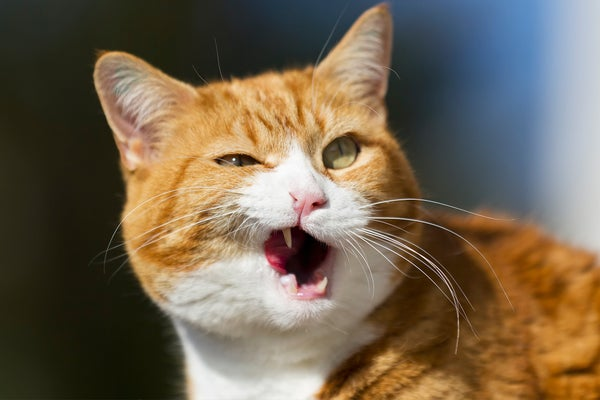

In [27]:
img

In [28]:
text_inputs = processor.apply_chat_template(inputs)

In [29]:
image_inputs = processor.preprocess_image(inputs)

In [30]:
print(text_inputs)

<|im_start|>system
You are a helpful multimodal AI assistant named simpleVLM, built by shreydan.<|im_end|>

Answer based on the image context:
<|start_of_image|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|><|image_token|

In [31]:
image_inputs.shape

torch.Size([3, 512, 512])

In [32]:
model_inputs = processor(inputs)

In [33]:
{k:v.shape for k,v in model_inputs.items()}

{'input_ids': torch.Size([1, 306]),
 'pixel_values': torch.Size([1, 3, 512, 512])}

In [34]:
from text_model import LLaMA
from vision_model import VisionEncoder
from finetune_utils import update_embeddings, load_text_weights, Config

In [35]:
class SimpleVLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.vision_model = VisionEncoder(self.config.embed_dim).to(dtype=self.config.dtype)
        self.text_model = LLaMA(self.config)

    def _prepare_for_training(self):
        self.text_model = load_text_weights(self.text_model)
        self.text_model = update_embeddings(
            self.text_model,
            old_vocab_size=self.config.vocab_size,
            new_vocab_size=self.config.vocab_size + 3,
            dim = self.config.embed_dim
        )

    def forward(self, input_ids, pixel_values=None):

        x = self.text_model.embed_tokens(input_ids)

        if pixel_values is not None:
            image_tokens = self.vision_model(pixel_values)
            _image_token_positions = torch.where(input_ids == self.config.image_token_id)
            x[_image_token_positions] = image_tokens
        
        for layer in self.text_model.layers:
            x = layer(x)
            
        x = self.text_model.norm(x)
        logits = self.text_model.lm_head(x)
        
        return logits

In [36]:
config = Config(
    embed_dim = 576,
    intermediate_dim = 1536,
    max_position_embeddings = 8192,
    base_theta = 100000,
    num_q_heads = 9,
    num_kv_heads = 3,
    attn_dropout = 0.,
    num_layers = 30,
    vocab_size = 49152,
    dtype = torch.bfloat16,
    eos_token_id = 2,
    image_start_token_id = 49152,
    image_end_token_id = 49153,
    image_token_id = 49154
)

In [37]:
model = SimpleVLM(config)

In [38]:
model._prepare_for_training()

new_embedding_weight torch.Size([49155, 576])


In [39]:
outputs = model(**model_inputs)

In [40]:
outputs.shape

torch.Size([1, 306, 49155])

In [42]:
torch.allclose(model.text_model.embed_tokens.weight, model.text_model.lm_head.weight)

True

In [43]:
model

SimpleVLM(
  (vision_model): VisionEncoder(
    (vision): SiglipVisionModel(
      (vision_model): SiglipVisionTransformer(
        (embeddings): SiglipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
          (position_embedding): Embedding(1024, 768)
        )
        (encoder): SiglipEncoder(
          (layers): ModuleList(
            (0-11): 12 x SiglipEncoderLayer(
              (self_attn): SiglipSdpaAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
                (q_proj): Linear(in_features=768, out_features=768, bias=True)
                (out_proj): Linear(in_features=768, out_features=768, bias=True)
              )
              (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
              (mlp): SiglipMLP(
                (activation_fn): PytorchGELUTanh()
          